In [1]:
import math as m
import h5py 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import h5py
class Antenna:
    """ antenna with location and timeseries of Efield"""
    def __init__(self,x,y,z,name=""):
        self.x = x
        self.y = y
        self.z = z
        self.name = name

class REvent:
    """ An interface class for reading simulations """
    def __init__(self,filename):
        self.reasfile = filename
        if '.reas' in filename:
            self.reasfile = filename
            self.parse_reas()
        elif '.hdf5' in filename:
            self.hdf5file = filename
            self.parse_hdf5()

    def parse_reas(self):
        """ parse *reas file """
        f = open(self.reasfile)
        lines = f.readlines()
        for l in lines:
            if 'ShowerZenithAngle' in l:
                self.zenith = float(l.split()[2])
            if 'ShowerAzimuthAngle' in l:
                self.azimuth = float(l.split()[2]) + 180
                if self.azimuth > 360:
                    self.azimuth = self.azimuth - 360
            if 'DepthOfShowerMaximum' in l:
                self.xmax = float(l.split()[2])
            if 'PrimaryParticleEnergy' in l:
                self.energy = float(l.split()[2])/1e18
            if 'PrimaryParticleType' in l:
                self.part_id = int(l.split()[2])
            if 'MagneticFieldInclinationAngle' in l:
                self.Binc = float(l.split()[2])
            if 'MagneticFieldStrength' in l:
                self.Bmag = float(l.split()[2])
        self.parse_reas_antenas()
        self.set_unit_vectors()

    def parse_reas_antenas(self):
        """Parse the antennas by reas """
        self.listfile = self.reasfile.replace('.reas','.list')
        f = open(self.listfile)
        lines = f.readlines()
        self.antennas = []
        print('reading ' +  str(len(lines)) + ' antennas')
        for l in lines:
            a = Antenna(float(l.split()[2])/100,float(l.split()[3])/100,float(l.split()[4])/100,l.split()[5])
            efile = self.listfile.replace('.list','_coreas/raw_'+ a.name + '.dat')
            a.t, a.Ex, a.Ey, a.Ez = np.loadtxt(efile,unpack=True)
            a.t = np.asarray(a.t)*1e9 #use nanoseconds
            a.Ex = np.asarray(a.Ex) * 2.99792458e10 #cgs statvolt/cm volt -> mu V/m (SI)
            a.Ey = np.asarray(a.Ey) * 2.99792458e10 #cgs statvolt/cm volt-> mu V/m (SI)
            a.Ez = np.asarray(a.Ez) * 2.99792458e10 #cgs statvolt/cm volt-> mu V/m (SI)
            self.antennas.append(a)

    def parse_hdf5(self):
        f = h5py.File(self.hdf5file, "r")
        self.antennas = []
        ai = f[list(f.keys())[-1] + '/AntennaInfo']
        for ai_ in ai:
            a = Antenna(ai_[1],ai_[2],ai_[3],ai_[0].decode('UTF-8'))
            self.antennas.append(a)
        print('reading ' +  str(len(self.antennas)) + ' antennas')

        traces = f[list(f.keys())[-1] + '/AntennaTraces']
        for tr in traces:
            for a in self.antennas:
                if a.name == tr:
                    break
            a.t = []
            a.Ex = []
            a.Ey = []
            a.Ez =[]
            for tup in traces[tr + '/efield']:
                a.t.append(tup[0])
                a.Ex.append(tup[1])
                a.Ey.append(tup[2])
                a.Ez.append(tup[3])
            a.t = np.asarray(a.t)
            a.Ex = np.asarray(a.Ex)
            a.Ey = np.asarray(a.Ey)
            a.Ez = np.asarray(a.Ez)

        ei = f[list(f.keys())[-1] + '/EventInfo']
        ei=ei[0]
        self.zenith = 180.-ei[4]
        self.azimuth = ei[5]+180
        if self.azimuth >= 360:
            self.azimuth -= 360
        self.xmax = ei[9]
        self.energy = ei[3]
        self.part_id = ei[2].decode('UTF-8')
        self.Bmag = ei[16]
        self.Binc = ei[17]
        self.Bdec = ei[18]
        self.ground=ei[11]
        self.dist_xmax=ei[6]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
file='/home/anthony/Documents/Stshp_Iron_0.0251_74.8_0.0_25.hdf5'

ev = REvent(file)
x = np.asanyarray([a.x for a in ev.antennas])
y = np.asanyarray([a.y for a in ev.antennas])
z = np.asanyarray([a.z for a in ev.antennas])
maxVals = [np.max([np.max(a.Ex),np.max(a.Ey),np.max(a.Ez)])for a in ev.antennas]
lmaxVals=np.asanyarray( np.log10(maxVals))
cut = lmaxVals>-8


reading 176 antennas


(-2000.0, 2000.0)

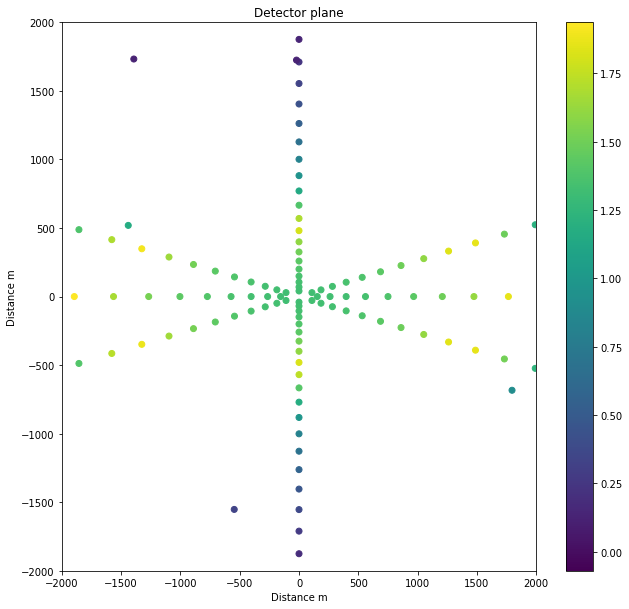

In [4]:
fig = plt.figure()
plt.scatter(x[cut],y[cut],c=lmaxVals[cut])
plt.colorbar()
plt.title("Detector plane")
plt.xlabel("Distance m")
plt.ylabel("Distance m")
plt.tight_layout()
fig.set_size_inches(10, 10)
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)


In [5]:
print(ev.zenith,ev.azimuth,ev.Binc)

74.76 0.0 60.79


In [6]:

def vxvxb(zenith,azimuth,Binc):
    '''  v b vxb vxvxb '''
    '''calculating v b vxb and vxvxb unit vectors for shower coordinate transformation'''
    zenith= np.deg2rad(zenith)
    azimuth = np.deg2rad(azimuth)
    Binc= np.deg2rad(Binc)
    v = np.array([-np.sin(zenith)*np.cos(azimuth),-np.sin(zenith)*np.sin(azimuth),-np.cos(zenith)])
    # in the direction opp to the shower axis
    B = np.array([np.cos(Binc),0,-np.sin(Binc)])
    vxB=np.cross(v,B)/np.linalg.norm(np.cross(v,B))
    vxvxB=np.cross(v,vxB)/np.linalg.norm(np.cross(v,vxB))
    #print('unit v',v)
    #print('unit B',B)
    #print('unit vxb',vxB)
    #print('unit vxvxb',vxvxB)
    #print('vxB',np.cross(vxvxB,v))
    #print('vxb dot vxvxb =',np.dot(vxB,vxvxB))
    #print('v dot vxb =',np.dot(v,vxB))
    #print('v dot vxvxb =',np.dot(vxvxB,v))
    #print('v mag',np.sqrt(v.dot(v)))
    #print('B mag',np.sqrt(B.dot(B)))
    #print('vxb mag',np.sqrt(vxB.dot(vxB)))
    #print('vxvxb mag',np.sqrt(vxvxB.dot(vxvxB)))
    return v,vxB,vxvxB
   
       
v=vxvxb(ev.zenith,ev.azimuth,ev.Binc)[0]
vxB=vxvxb(ev.zenith,ev.azimuth,ev.Binc)[1]
vxvxB=vxvxb(ev.zenith,ev.azimuth,ev.Binc)[2]

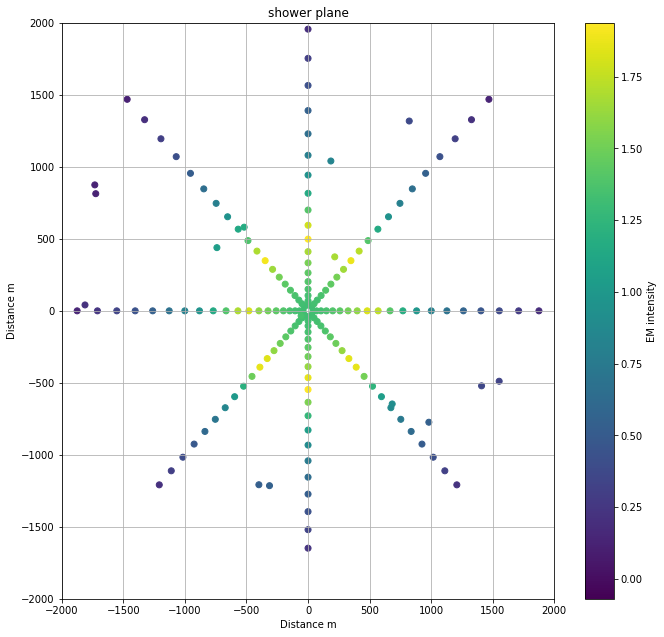

In [7]:
path = "/home/anthony/Documents/"
filename = 'Stshp_Iron_0.0251_74.8_0.0_25'
events = path+filename+".hdf5"
file = h5py.File(events, 'r') # Opening a HDF5-file, for reading only

'''  v b vxb vxvxb '''

''' detector plane antenna coordinates '''
proton_data = file[filename]
primary_direction = file['RunInfo']['Zenith'][0], file['RunInfo']['Azimuth'][0]
antenna_info = proton_data['AntennaInfo']
coords = np.zeros((3, len(antenna_info)))
coords[0] = antenna_info['X']
coords[1] = antenna_info['Y']
coords[2] = antenna_info['Z']-1086

''' det 2 showerplane tranformation v, (vxB), (vx(vxB)) '''
showercoords = np.zeros((3, len(antenna_info)))
showercoords[0] = vxB[0]*coords[0] + vxB[1]*coords[1] + vxB[2]*coords[2]
showercoords[1] = vxvxB[0]*coords[0] + vxvxB[1]*coords[1] + vxvxB[2]*coords[2]
showercoords[2] = v[0]*coords[0] + v[1]*coords[1] + v[2]*coords[2]


fig = plt.figure()
plt.scatter(showercoords[0],showercoords[1] ,c=lmaxVals[cut],alpha=1)
plt.colorbar(label="EM intensity")
plt.title("shower plane")
plt.xlabel("Distance m")
plt.ylabel("Distance m")
plt.grid()
plt.xlim(-2000,2000)
plt.ylim(-2000,2000)
plt.tight_layout()
fig.set_size_inches(10.5, 10.5)

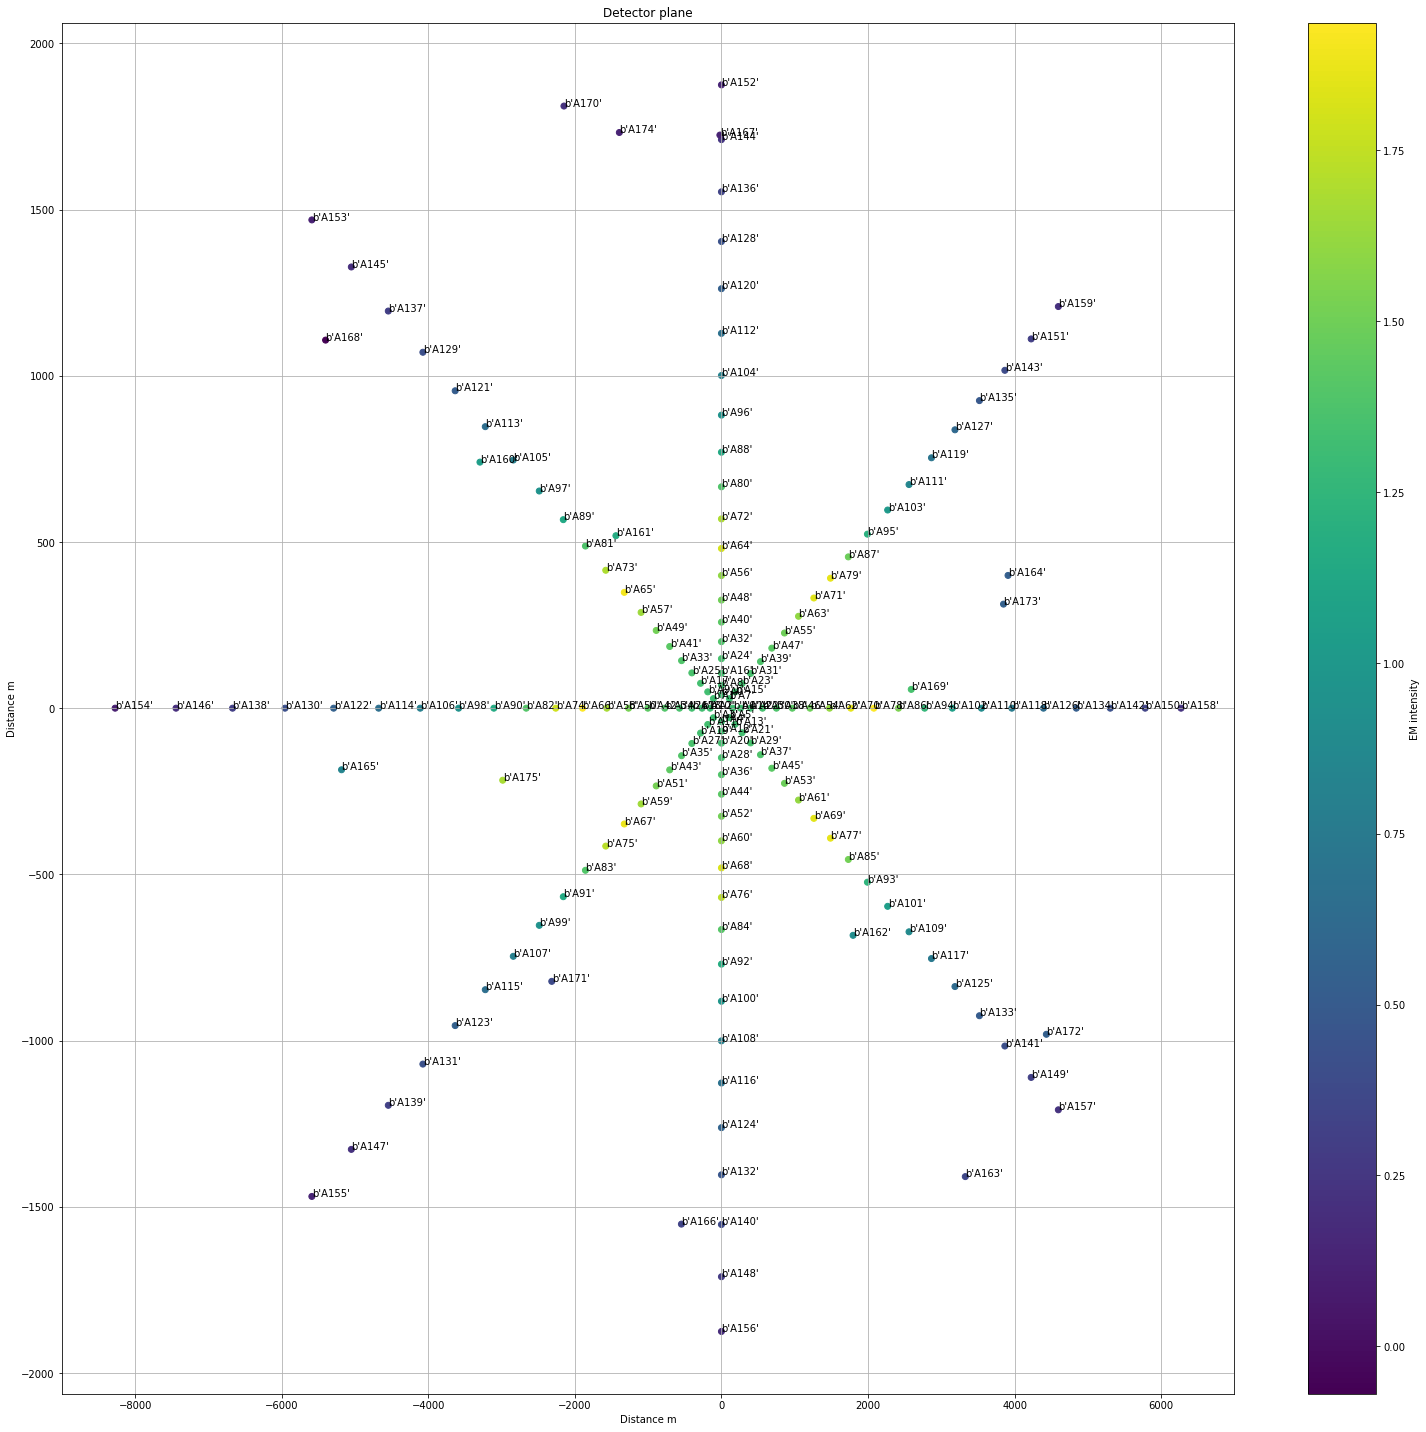

In [23]:
import re
'''naming antenna traces'''
fig = plt.figure()
#plt.scatter(showercoords[0],showercoords[1] ,c=lmaxVals[cut],alpha=1)
#plotting antena names on the detector plane coordinates 
plt.scatter(x[cut],y[cut],c=lmaxVals[cut])
plt.colorbar(label="EM intensity")
plt.title("Detector plane")
plt.xlabel("Distance m")
plt.ylabel("Distance m")
plt.grid()
#plt.xlim(-1000,1000)
#plt.ylim(-1000,1000)
plt.tight_layout()
fig.set_size_inches(25, 25)
#plt.annotate(Antenna,(x,y),Antenna, fontsize=12)
Aname=[]
for i, txt in enumerate(antenna_info):
    for catch in re.finditer(b'A[\d][\d]*', txt):
        Aname.append(catch[0]) 
            #print(catch[0]) # catch is a match object
        #print(catch[0], x[i], y[i])
        plt.annotate(catch[0], (x[i], y[i]))
plt.show()


In [21]:
import scipy
from scipy import signal
from scipy.signal import filtfilt
from scipy.fftpack import fft, ifft, fftfreq,rfft


def bandPassFilter(signal,fs,lowcut=0.03, hicut=0.08, order = 6):#GHz
    '''Returns filtered signal using thr butter worth filter of order 6'''
    niq=fs/2
    low= lowcut/niq
    high=hicut/niq
   
    b,a=scipy.signal.butter(order,[low,high],'bandpass',analog=False)
    y = scipy.signal.filtfilt(b,a,signal)
    return (y)

def squarband(time,data, low=0.03, high=0.08):
    '''retuens filters sigal from a squarband filter'''
    y_rel_plot=[]
    N=np.array(data).size
    time=ev.antennas[0].t
    dt= time[1]-time[0]# interval between steps
    yf=fft(data)
    xf =fftfreq(N, dt)#[:round(N/2+1)]
    freq=np.linspace(0,1/dt,N)
    for index in range(len(xf)):
        if low<abs(xf[index])<high:
            y_rel_plot=np.append(y_rel_plot,yf[index])      
        else:
            y_rel_plot=np.append(y_rel_plot,0)
    index+=1

    y_recon=np.fft.ifft(y_rel_plot)
    return y_recon


def read_Efields(filename, antenna):
    ''' read eM fields of a particular antenna Ex Ey Ez Et\n also plot'''
    Ex = file[filename]['AntennaTraces'][antenna]['efield']['Ex']
    Efield = np.zeros((4, len(Ex[::4])))
    Efield[0] = Ex[::4]
    Ey = file[filename]['AntennaTraces'][antenna]['efield']['Ey']
    Efield[1] = Ey[::4]
    Ez = file[filename]['AntennaTraces'][antenna]['efield']['Ez']
    Efield[2] = Ez[::4] 
    time = file[filename]['AntennaTraces'][antenna]['efield']['Time']
    Efield[3] = time[::4]
    return Efield

def E_normA(filename,Antenna='A0'):
    '''calculatint normal eM field in norm'''
    vectors =read_Efields(filename, 'A115')[0:3]
    vectors.reshape(vectors.shape[1],vectors.shape[0])
    Enorm = np.linalg.norm(vectors, axis=0)
    return Enorm



In [14]:
def plot_trac(filename, antenna):
    '''making plots of individual antenna traces'''
    Efield=read_Efields(filename, antenna)
    Anum=int(re.search(r'\d+',antenna)[0])
    dt=Efield[3][1]-Efield[3][0]
    freq=np.linspace(0,1/dt,len(Efield[3]))
   
    print('A'+str(Anum)+'  x ='+str(x[cut][Anum])+', y ='+str(y[cut][Anum]))
    plt.subplot(121)
    plt.plot(Efield[3],Efield[0],alpha=0.4,label='Ex')
    plt.plot(Efield[3],Efield[1],alpha=0.4,label='Ey')
    plt.plot(Efield[3],Efield[2],alpha=0.4,label='Ez')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V/m')
    plt.title('signal D plane')
#plt.xlim(-50,200)
    plt.legend()

    plt.subplot(122)
    Efvb=Efield[0]*vxB[0]+Efield[1]*vxB[1]+Efield[2]*vxB[2]
    Efvvb=Efield[0]*vxvxB[0]+Efield[1]*vxvxB[1]+Efield[2]*vxvxB[2]
    Efv=Efield[0]*v[0]+Efield[1]*v[1]+Efield[2]*v[2]
    plt.plot(Efield[3],Efvb,alpha=0.75,label='vbE')
    plt.plot(Efield[3],Efvvb,alpha=0.75,label='vvbE')
    plt.plot(Efield[3],Efv,alpha=0.75,label='vE')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V/m')
    plt.title('signal s plane')
    #plt.xlim(-10,50)
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=1)
    plt.legend()

    plt.show()


    plt.subplot(121)
    plt.plot(freq,abs(fft(Efield[0])),alpha=0.4,label='Ex')
    plt.plot(freq,abs(fft(Efield[1])),alpha=0.4,label='Ey')
    plt.plot(freq,abs(fft(Efield[2])),alpha=0.4,label='Ez')
    plt.xlabel('GHz')
    plt.ylabel('Amp')
    plt.xlim(0,0.25)
    plt.legend()
    #plt.xlim(-50,200)
    plt.legend()

    plt.subplot(122)
    plt.plot(freq,abs(fft(Efvb)),alpha=0.75,label='vbE')
    plt.plot(freq,abs(fft(Efvvb)),alpha=0.75,label='vvbE')
    plt.plot(freq,abs(fft(Efv)),alpha=0.75,label='vE')
    plt.xlabel('GHz')
    plt.ylabel('Amp')
    plt.xlim(0,0.25)
    plt.legend()
    plt.title('signal s plane')
    #plt.xlim(-10,50)
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=1)
    plt.legend()

    plt.show()

    plt.subplot(121)
    plt.plot(Efield[3],bandPassFilter(Efvb,1/dt,0.030,0.08),label='vbE')
    plt.plot(Efield[3],bandPassFilter(Efvvb,1/dt,0.030,0.08),label='vvbE')
    plt.plot(Efield[3],bandPassFilter(Efv,1/dt,0.030,0.08),label='vE')
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V/m') 
    #plt.xlim(-50,200)
    plt.legend()

    plt.subplot(122)
    plt.plot(Efield[3],squarband(Efield[3],Efvb),'-',label='vbE')
    plt.plot(Efield[3],squarband(Efield[3],Efvvb),'-',label='vvbE')
    plt.plot(Efield[3],squarband(Efield[3],Efv),'-',label='vE')
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=1)
    plt.xlabel('nano sec')  
    plt.ylabel('$\mu$V/m') 
    plt.legend()
    plt.show()

    plt.subplot(121)
    plt.plot(freq,abs(fft(bandPassFilter(Efvb,1/dt,0.030,0.08))),label='vbE')
    plt.plot(freq,abs(fft(bandPassFilter(Efvvb,1/dt,0.030,0.08))),label='vvbE')
    plt.plot(freq,abs(fft(bandPassFilter(Efv,1/dt,0.030,0.08))),label='vE')
    plt.xlabel('GHz')
    plt.ylabel('Amp')
    plt.xlim(0,0.25)
    plt.legend()

    plt.subplot(122)
    plt.plot(freq,abs(fft(squarband(Efield[3],Efvb,0.030,0.08))),'-',label='vbE')
    plt.plot(freq,abs(fft(squarband(Efield[3],Efvvb,0.030,0.08))),'-',label='vvbE')
    plt.plot(freq,abs(fft(squarband(Efield[3],Efv,0.030,0.08))),'-',label='vE')
    plt.xlim(0,0.25)
    plt.xlabel('GHz')
    plt.ylabel('Amp')
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=1)
    plt.legend()
    plt.show()
    return

A4  x =-0.0, y =-40.63


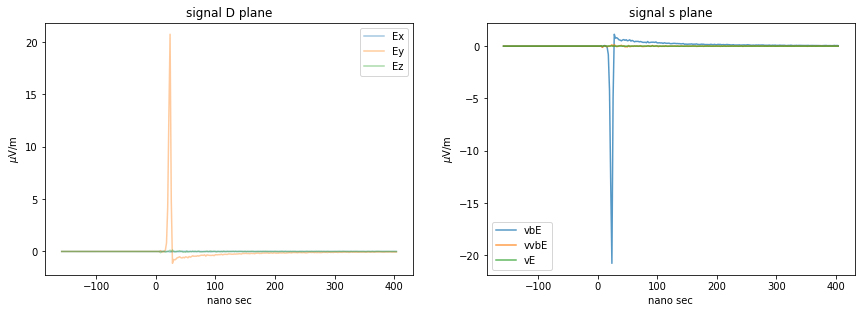

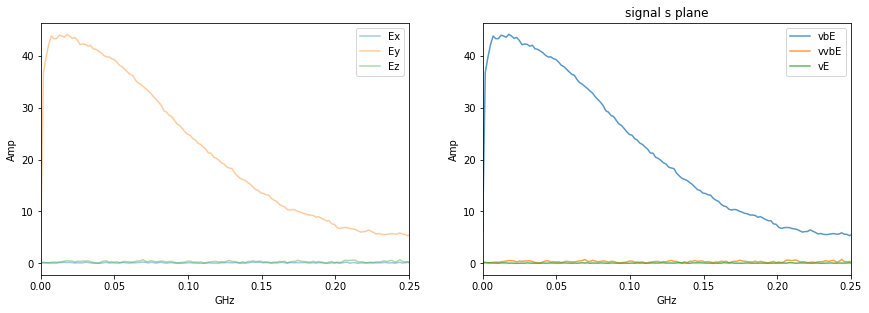

/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


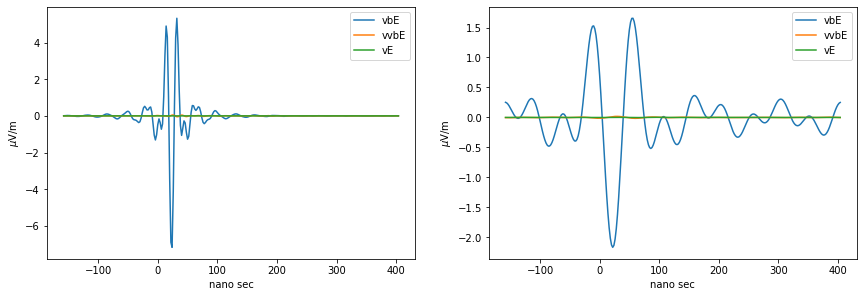

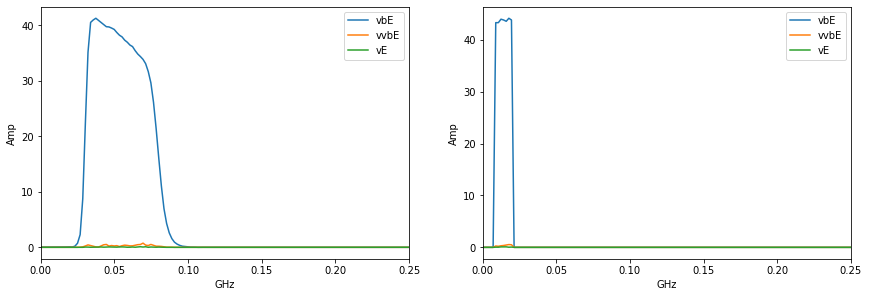

In [16]:
antenna='A4'
plot_trac(filename, antenna)

A68  x =-0.0, y =-480.52


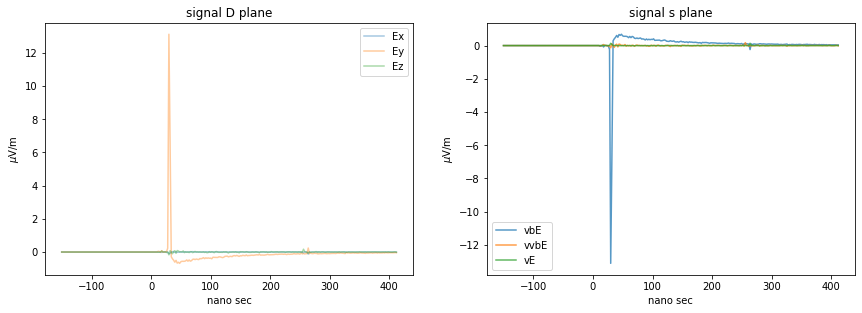

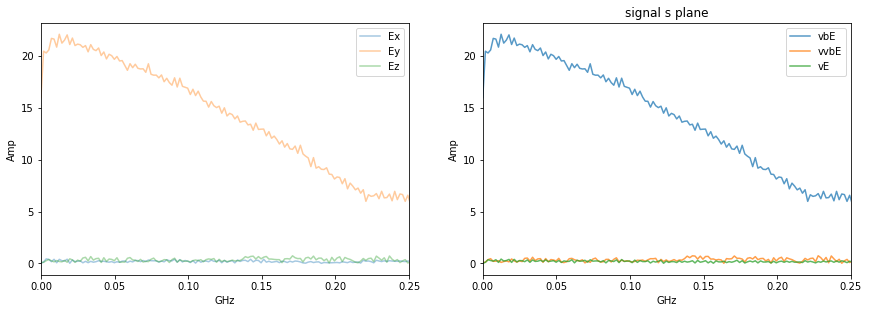

/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


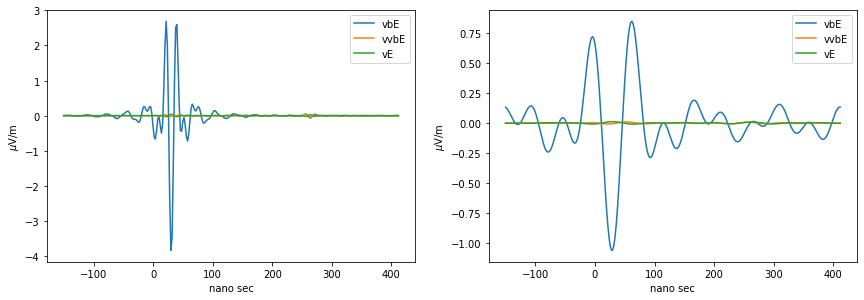

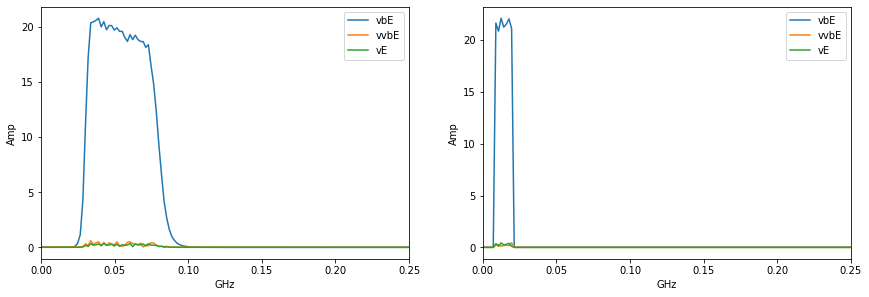

In [17]:
antenna='A68'
plot_trac(filename, antenna)

A100  x =-0.0, y =-881.78


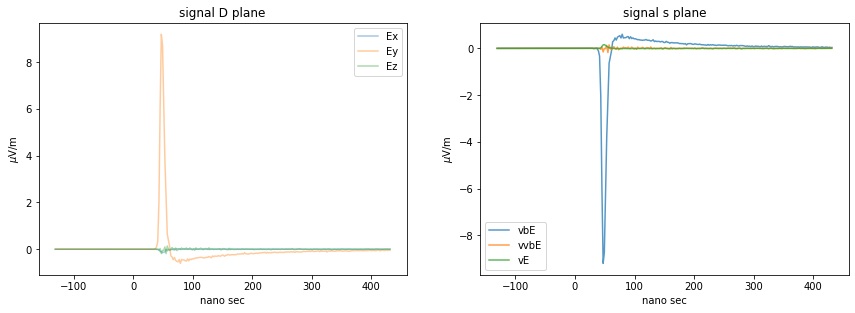

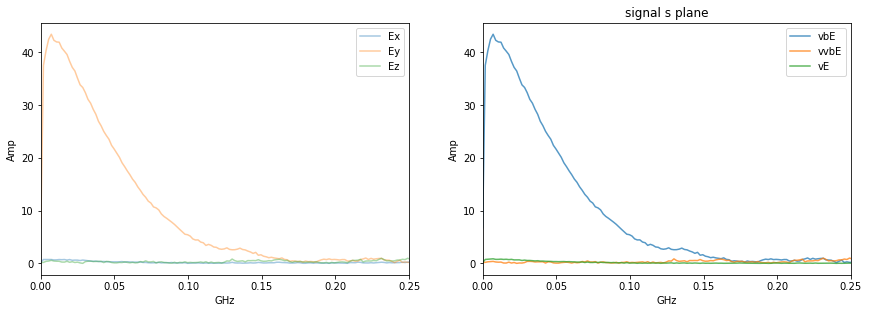

/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/snap/root-framework/477/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


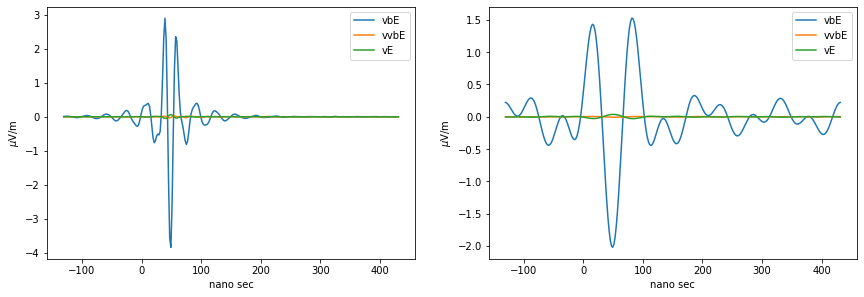

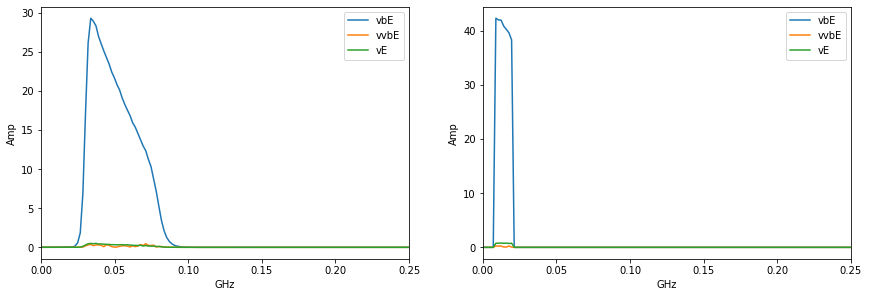

In [18]:
antenna='A100'
plot_trac(filename, antenna)

In [19]:
def em_T(Efield,v,vxB,vxvxB):
    '''transfroming the em field to the v,vxb,vxvxB'''
    ETfields = np.zeros((3, int(Efield.size/4)))
    ETfields[0]=Efield[0]*vxB[0]+Efield[1]*vxB[1]+Efield[2]*vxB[2]
    ETfields[1]=Efield[0]*vxvxB[0]+Efield[1]*vxvxB[1]+Efield[2]*vxvxB[2]
    ETfields[2]=Efield[0]*v[0]+Efield[1]*v[1]+Efield[2]*v[2]
    #plt.plot(Efield[3],ETfields[0],alpha=0.75)
    #plt.plot(Efield[3],Etfields[1],alpha=0.75)
    #plt.xlabel('nano sec')  
    #plt.ylabel('$\mu$V') 
    return ETfields



def em_Tnorm(ETfields):
    '''calculates the normatlised vector of the transfromed electric fields'''
    ETfields.reshape(ETfields.shape[1],ETfields.shape[0])
    ETnorm = np.linalg.norm(ETfields, axis=0)
    return ETnorm
